# Metadata

```yaml
Course:    DS 5001
Module:    09 Lab
Topic:     Word2Vec
Author:    R.C. Alvarado
Date:      27 March 2024 (revised)
```

**Purpose:** We create word embeddings with novel data using word2vec and visualize results with tSNE.

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
# Adjust this for a new corpus
data_prefix = 'novels'
table_dir =  f'{data_home}/{data_prefix}'
OHCO = ['book', 'chapter', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4] # Paragraphs
SENT = OHCO[:5] # Sentences
BAG = PARA
# BAG = SENT

In [3]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [4]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE
import plotly_express as px

In [5]:
import gensim
gensim.__version__

'4.3.0'

# Import `TOKENS` and `VOCAB`

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [6]:
TOKENS = pd.read_csv(f'{table_dir}/{data_prefix}-TOKENS.csv').set_index(OHCO)

In [7]:
TOKENS.head()

pos     term_str  term_id
book            chapter para_num sent_num token_num                           
secretadversary 1       0        1        0           DT          the    24127
                                          1          NNP        young    27354
                                          2          NNP  adventurers      399
                                          3          NNP          ltd    14406
                        1        0        0           JJ        tommy    24529

In [8]:
VOCAB = pd.read_csv(f'{table_dir}/{data_prefix}-VOCAB.csv').set_index('term_str')

In [9]:
VOCAB = VOCAB[~VOCAB.index.isna()] # There is NaN in the index for some reason

In [10]:
VOCAB.sample(5)

term_id    n             p port_stem  stop  df       idf  tfidf_sum  \
term_str                                                                        
styles      23263   53  3.532351e-05     style     0  12  1.425969  75.576343   
veil        26088  113  7.531240e-05      veil     0  59  0.734298  82.975670   
geologic    10355    1  6.664814e-07    geolog     0   1  2.505150   2.505150   
lacking     13630    1  6.664814e-07      lack     0   1  2.505150   2.505150   
sublimer    23287    1  6.664814e-07    sublim     0   1  2.505150   2.505150   

          tfidf_mean  tfidf_max pos_max  
term_str                                 
styles      0.236176  14.259687     NNP  
veil        0.259299   8.077278      NN  
geologic    0.007829   2.505150      NN  
lacking     0.007829   2.505150      JJ  
sublimer    0.007829   2.505150     JJR

# Convert to Gensim

We now create a Gensim-style corpus of docs, a list of lists of tokens.

In [11]:
docs = TOKENS[~TOKENS.pos.str.match('NNPS?')].dropna(subset='term_str')\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [12]:
print(docs[:2])

[['to', 'she', 'is', 'always', 'woman'], ['i', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other', 'name']]


In [53]:
vocab = Dictionary(docs)

# Generate word embeddings with Gensim's module

In [14]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [15]:
model.wv.vectors

array([[-0.35448733,  0.01237649,  0.27643257, ...,  0.25913143,
         0.17726643, -0.5278335 ],
       [ 0.88556015,  0.14659066, -1.0930866 , ..., -0.2702318 ,
         0.03238007, -0.31432092],
       [-0.18934022, -0.47601682,  0.1864422 , ..., -0.51783824,
         0.17457211,  0.19726561],
       ...,
       [ 0.17377047, -0.13707577,  0.02523172, ..., -0.05781796,
         0.03161978,  0.1333937 ],
       [ 0.02313133,  0.02827321,  0.10950555, ...,  0.02147535,
         0.19660306, -0.13109013],
       [ 0.08367148, -0.10818789,  0.07010768, ...,  0.11829419,
         0.03246289, -0.08886177]], dtype=float32)

# Visualize with tSNE

## Convert model to data frame

In [16]:
# VOCAB['gsid'] = pd.DataFrame([i for i in vocab.items()], columns=['gsid', 'term_str']).set_index('term_str')
# VOCAB = VOCAB.dropna(subset='gsid').copy()
# VOCAB.gsid = VOCAB.gsid.astype(int)

In [17]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [18]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [19]:
WV

0         1         2         3         4         5    \
term_str                                                                
a         -0.961040 -0.994452 -0.034648  1.155024 -0.927950 -0.532759   
abandoned  0.009735 -0.123573  0.149560  0.041613 -0.090462  0.007683   
abbess    -0.059592 -0.065640  0.028593 -0.019819 -0.154248 -0.039330   
able       0.308349 -1.059986  0.141782 -0.103005  0.171008  0.034882   
about     -0.065277 -0.548271 -0.307708  0.275152  0.509350 -0.287098   
...             ...       ...       ...       ...       ...       ...   
youre      0.169755 -0.065567 -0.239334  0.117878  0.117670 -0.033297   
yours     -0.166527 -0.240182 -0.011099 -0.004306  0.270852  0.086586   
yourself  -0.173909 -0.082667 -0.510902 -0.007150  0.646104  0.393213   
youth      0.021026  0.094308  0.093595  0.057915 -0.085368 -0.002986   
youve     -0.074059 -0.180094 -0.073961  0.044032  0.043055  0.105593   

                6         7         8         9    ...       236       237  \
term_str                                           ...                       
a         -1.440889 -0.462185 -0.503136  0.178743  ... -0.364430 -0.372645   
abandoned  0.048370 -0.020448 -0.160019 -0.118351  ... -0.045834  0.117901   
abbess    -0.235712 -0.026811 -0.027758 -0.049071  ...  0.059866  0.124960   
able      -0.418639  0.167558 -0.517321 -0.141177  ... -0.209680  0.733641   
about      1.025738 -0.373285 -0.029654  0.286665  ...  0.312701  0.264481   
...             ...       ...       ...       ...  ...       ...       ...   
youre     -0.319867  0.058409 -0.131346  0.205378  ...  0.112301  0.326794   
yours     -0.176032 -0.064049  0.024446 -0.012005  ... -0.023451 -0.008298   
yourself  -0.353191  0.312442 -0.064357 -0.047400  ...  0.118915  0.290522   
youth     -0.302125  0.031715 -0.068411 -0.017601  ...  0.205266 -0.022708   
youve     -0.002625  0.026591 -0.018164  0.258651  ... -0.005253  0.214172   

                238       239       240       241       242       243  \
term_str                                                                
a         -0.015916  0.472248 -0.218827  0.135892 -0.358798  0.045911   
abandoned -0.057428 -0.127267  0.176381  0.064119  0.039474  0.082807   
abbess     0.017895 -0.041964  0.051568  0.038349  0.026436  0.025086   
able      -0.135660 -0.100859 -0.120292 -0.109047 -0.141723  0.163862   
about     -0.182275 -0.569628 -0.160162  0.067824 -0.105358  0.075542   
...             ...       ...       ...       ...       ...       ...   
youre     -0.281349  0.144661 -0.304959 -0.224885 -0.128021  0.266432   
yours      0.036035  0.196186 -0.115350  0.136261 -0.015351 -0.110399   
yourself  -0.209408  0.406001 -0.139035 -0.072072 -0.146849  0.059178   
youth     -0.161268  0.073274  0.059931  0.041377  0.069024  0.195736   
youve      0.081975  0.048466 -0.178331 -0.213602 -0.114979  0.168993   

                244       245  
term_str                       
a         -0.581139 -1.074126  
abandoned  0.033157 -0.069431  
abbess     0.110327 -0.044480  
able      -0.166839  0.051810  
about      0.195694  0.130363  
...             ...       ...  
youre     -0.078942  0.272220  
yours     -0.402708 -0.023221  
yourself  -0.668906  0.385485  
youth     -0.024106  0.108299  
youve     -0.117289  0.250695  

[2435 rows x 246 columns]

## Use ScikitLearn's TSNE library

In [20]:
tsne_engine = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [21]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [22]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [23]:
TSNE

x          y
term_str                       
a         -13.231147  29.222832
abandoned   9.250174  18.226639
abbess    -10.130727  -4.415580
able       20.261801  19.916395
about     -18.996517  35.137550
...              ...        ...
youre      29.017029  12.364420
yours      25.535276  -3.728859
yourself   43.660191   7.477502
youth      10.404062 -10.201073
youve      25.601032  11.034440

[2435 rows x 2 columns]

## Plot the coordinates

In [24]:
X = TSNE.join(VOCAB, how='left')

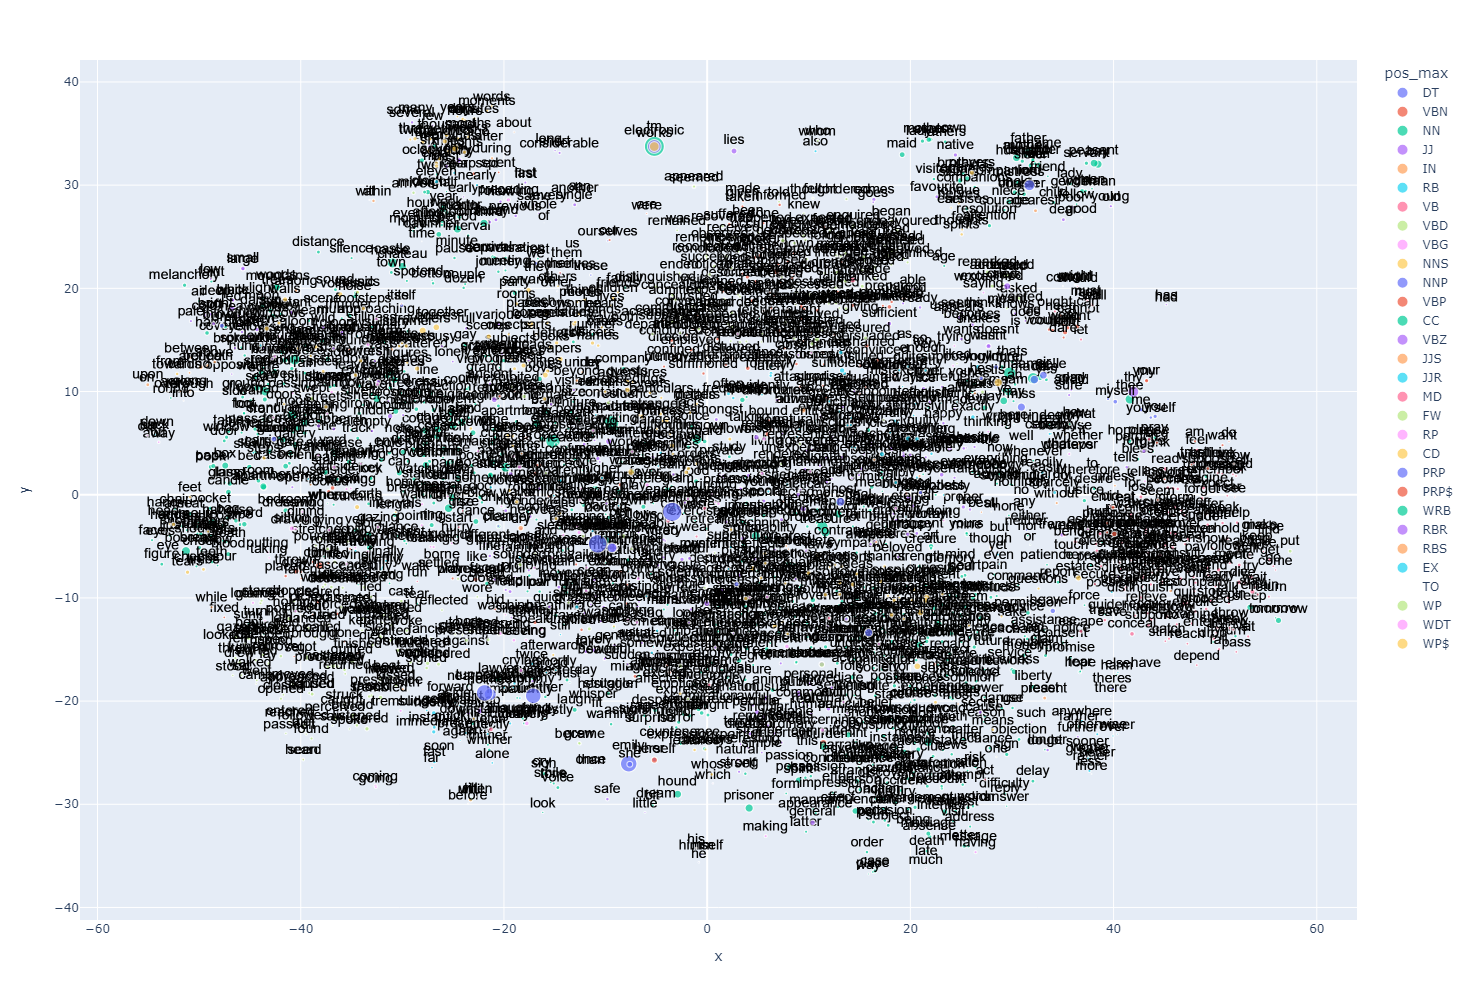

In [25]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_max', 
           hover_name='term_str',          
           size='tfidf_max',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [26]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [27]:
complete_analogy('man', 'boy', 'woman', 3)

term       sim
0     girl  0.763437
1  peasant  0.760286
2     lady  0.704671

In [28]:
complete_analogy('girl', 'daughter', 'boy', 3)

term       sim
0          wife  0.842495
1      mistress  0.827536
2  instructions  0.821378

In [29]:
complete_analogy('girl', 'sister', 'boy', 3)

term       sim
0  mistress  0.804521
1   prayers  0.781600
2      wife  0.768456

In [30]:
complete_analogy('man', 'gentleman', 'woman', 5)

term       sim
0     girl  0.824124
1    young  0.763570
2     lady  0.761459
3   fellow  0.702310
4  peasant  0.687455

In [31]:
complete_analogy('man', 'woman', 'gentleman', 5)

term       sim
0     girl  0.824124
1    young  0.763570
2     lady  0.761459
3   fellow  0.702310
4  peasant  0.687455

In [32]:
complete_analogy('woman', 'man', 'lady', 5)

term       sim
0  gentleman  0.711582
1       girl  0.702391
2     fellow  0.673088
3     friend  0.672492
4     doctor  0.666662

In [33]:
complete_analogy('day', 'night', 'sun', 5)

term       sim
0    clouds  0.803082
1      rain  0.801506
2      wind  0.790581
3      snow  0.783369
4  twilight  0.778683

In [34]:
complete_analogy('woman','answered','man', 5)

term       sim
0     added  0.673573
1   replied  0.661410
2      said  0.659220
3    saying  0.654863
4  remarked  0.648941

In [35]:
complete_analogy('man','replied','woman', 5)

term       sim
0   answered  0.707822
1       said  0.704028
2         oh  0.699726
3       dear  0.685886
4  exclaimed  0.678184

In [36]:
complete_analogy('wife', 'appeared', 'husband', 5)

term       sim
0      seemed  0.823266
1  considered  0.660992
2      served  0.651098
3      sought  0.648372
4        felt  0.648209

In [37]:
complete_analogy('husband', 'appeared', 'wife', 5)

term       sim
0         seemed  0.659135
1      described  0.617112
2       produced  0.574334
3  distinguished  0.562348
4      concluded  0.551304

In [38]:
complete_analogy('man', 'father', 'woman', 5)

term       sim
0    mother  0.875168
1   husband  0.833871
2      aunt  0.800817
3    sister  0.784827
4  daughter  0.782534

In [39]:
complete_analogy('man', 'husband', 'woman', 5)

term       sim
0    mother  0.834285
1      aunt  0.801431
2     niece  0.783476
3    father  0.781235
4  daughter  0.760852

In [40]:
complete_analogy('man', 'castle', 'woman', 5)

term       sim
0        chateau  0.740357
1        convent  0.730716
2          house  0.726915
3  neighbourhood  0.676623
4           town  0.660741

In [41]:
complete_analogy('woman', 'home', 'man', 5)

term       sim
0      off  0.623056
1    ready  0.619581
2  station  0.618246
3   supper  0.609959
4   dinner  0.600610

## Similarites

In [42]:
get_most_similar('joy')

term       sim
0  indignation  0.888504
1   tenderness  0.886723
2      delight  0.874797
3   admiration  0.867476
4        grief  0.859982
5       terror  0.839283
6       tender  0.836050
7  countenance  0.834247
8    gratitude  0.830022
9     emotions  0.827892

In [43]:
get_most_similar('man')

term       sim
0  gentleman  0.830054
1      woman  0.829314
2       girl  0.765771
3   creature  0.736881
4     fellow  0.708532
5     person  0.681113
6   stranger  0.679774
7    peasant  0.637207
8       lady  0.636948
9        boy  0.623414

In [44]:
get_most_similar(positive=['man'], negative=['woman'])

term       sim
0  together  0.308686
1     watch  0.301725
2       run  0.295850
3      them  0.290265
4      path  0.281351
5        he  0.279101
6      ship  0.277324
7      rest  0.276619
8       way  0.269460
9       off  0.267339

In [45]:
get_most_similar(positive='woman')

term       sim
0  gentleman  0.885990
1       girl  0.870770
2        man  0.829314
3   creature  0.773607
4     fellow  0.756880
5       lady  0.742327
6    peasant  0.736173
7   stranger  0.712279
8      young  0.677759
9    servant  0.663085

In [46]:
get_most_similar(positive=['woman'], negative=['man'])

term       sim
0  affectionate  0.425731
1         young  0.407127
2       beloved  0.396629
3        mother  0.369316
4        solemn  0.359835
5      inspired  0.354208
6         sweet  0.353268
7      charming  0.352459
8         looks  0.347079
9       shocked  0.345430

In [47]:
get_most_similar(['man','woman'],['boy','girl'])

term       sim
0      nor  0.503858
1     even  0.481126
2    human  0.451821
3       or  0.403191
4     make  0.396502
5  produce  0.395967
6   person  0.393715
7     real  0.391393
8   obtain  0.384804
9     pain  0.380510

# View with HAC

In [48]:
import sys
sys.path.append(local_lib)
from hac import HAC

In [49]:
WV2 = WV.join(VOCAB.pos_max)
WV2 = WV2[~WV2.pos_max.str.match(r"NNPS?")].iloc[:, :-1]

<Figure size 640x480 with 0 Axes>

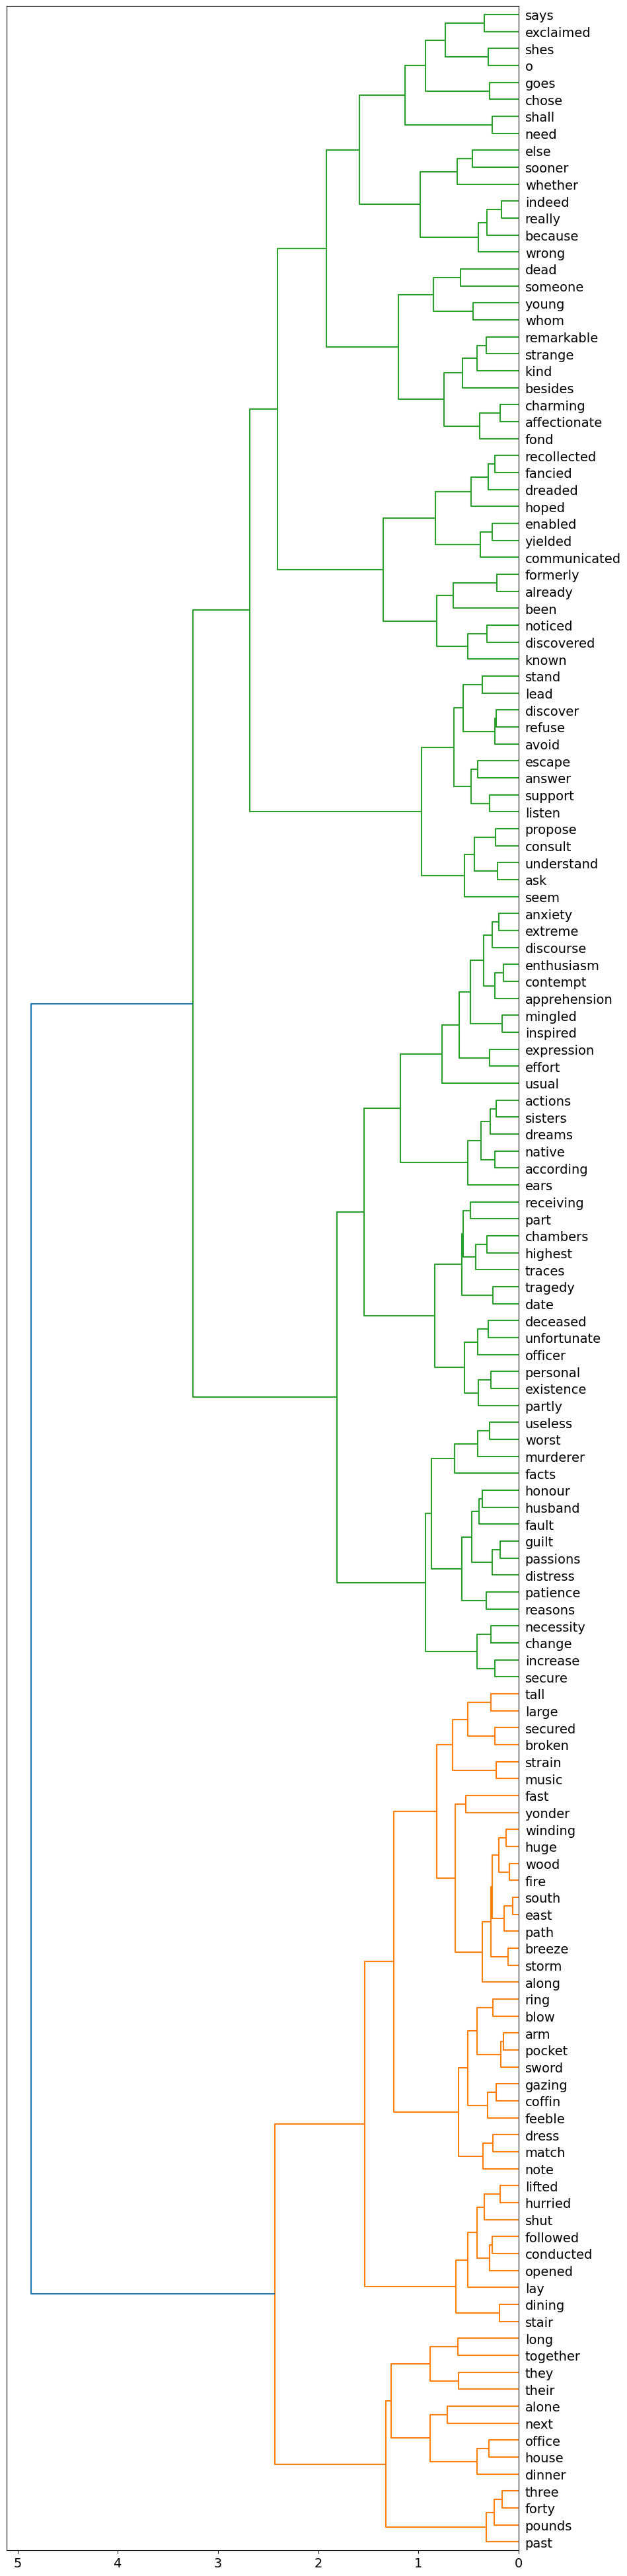

In [50]:
HAC(WV2.sample(150)).plot()

# Save

In [51]:
# W2V = pd.DataFrame(model.wv.vectors_norm, index=model.wv.vocab.keys())
# WV.to_csv('{}/{}-W2V.csv'.format(data_out, data_prefix))
# pd.Series(DOCS).to_csv('{}/{}-GENSIM_DOCS.csv'.format(data_out, data_prefix), index=False, header=False)